# Reduce Google location history data set

This notebook reduces the size of a Google location history data set down to a set of spatially representative points, with DBSCAN clustering. Visit https://accounts.google.com/ServiceLogin?service=backup to download your Google location history as a JSON file called LocationHistory.json.

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt

## Prep the data set

In [2]:
# load the full location history json file downloaded from google
df_gps = pd.read_json('data/LocationHistory.json')

In [3]:
# parse lat, lon, and timestamp from the dict inside the locations column
df_gps['lat'] = df_gps['locations'].map(lambda x: x['latitudeE7'])
df_gps['lon'] = df_gps['locations'].map(lambda x: x['longitudeE7'])
df_gps['timestamp_ms'] = df_gps['locations'].map(lambda x: x['timestampMs'])

In [4]:
# convert lat/lon to decimalized degrees and the timestamp to date-time
df_gps['lat'] = df_gps['lat'] / 10.**7
df_gps['lon'] = df_gps['lon'] / 10.**7
df_gps['timestamp_ms'] = df_gps['timestamp_ms'].astype(float) / 1000
df_gps['datetime'] = df_gps['timestamp_ms'].map(lambda x: dt.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

## Define the clustering functions

In [5]:
def get_centermost_point(cluster):
    centroid = MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid))
    return centermost_point

In [6]:
def dbscan_reduce(df, epsilon=0.01):
    
    coordinates = df.as_matrix(columns=['lon', 'lat'])    
    db = DBSCAN(eps=epsilon, min_samples=1).fit(coordinates)
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print 'Number of clusters: {:,}'.format(num_clusters)
    
    clusters = pd.Series([coordinates[cluster_labels == n] for n in range(num_clusters)])
    
    # find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # use list comprehension to extract the lat and lon out of the resulting points tuples as new dataframe columns
    longitudes = [point[0] for point in centermost_points]
    latitudes = [point[1] for point in centermost_points]
    rep_points = pd.DataFrame({'lon':longitudes, 'lat':latitudes})
    rep_points.tail()
    
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.apply(lambda row: df[(df['lat']==row['lat']) & (df['lon']==row['lon'])].iloc[0], axis=1)
    
    # all done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:0.2f}% compression.'
    print message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)))
    
    return rs

## Now cluster the data

In [7]:
# first cluster the full gps location history data set coarsely
df_clustered = dbscan_reduce(df_gps, epsilon=0.05)

Number of clusters: 470
Clustered 1,058,610 points down to 470 points, for 99.96% compression.


The previous clustering reduces dense clusters of points to a single point. Because min_samples=1, no point is noise - if there was a single gps reading in the middle of nowhere, it will be retained as a cluster/point. If the points were too dense along a linear strip, such as a highway, it will remove the entire line of points and leave just one behind, in the middle. To fix this, let's thin out the data set by retaining every 10th point as df_sampled. Then, combine df_sampled with df_clustered, and re-cluster once again to reduce the thinned-out data set. The final product will retain lonely points in the middle of nowhere (that would otherwise possibly be lost by merely sampling every 10th point) and will not strip out long linear corridors of dense points (that were removed in the first clustering step).

In [8]:
# next, sample every nth row of the full gps location history data set
sample_rate = 35
df_sampled = df_gps.iloc[range(0, len(df_gps), sample_rate)]
len(df_sampled)

30246

In [9]:
# combine the clustered and sampled sets
df_combined = pd.concat([df_clustered, df_sampled], axis=0)
df_combined = df_combined.reset_index().drop(labels='index', axis=1)

In [10]:
# then reduce by clustering again, finely this time
df_final = dbscan_reduce(df_combined, epsilon=0.001)

Number of clusters: 2,590
Clustered 30,716 points down to 2,590 points, for 91.57% compression.


In [11]:
# save to csv
df_final.to_csv('data/location-history-clustered.csv', index=False, encoding='utf-8')

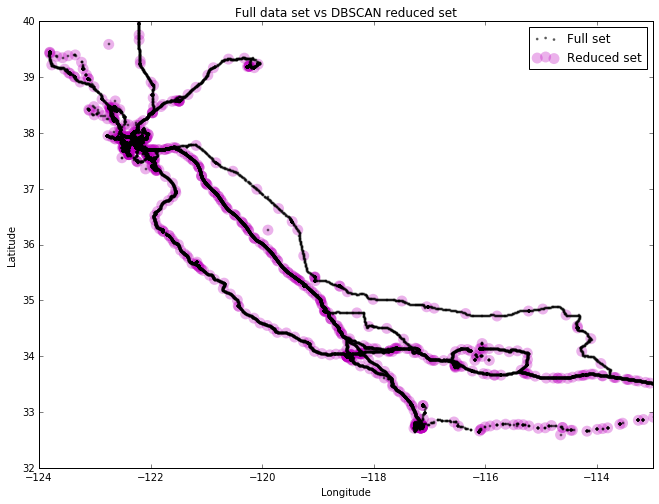

In [12]:
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_final['lon'], df_final['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df_gps['lon'], df_gps['lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# show just for california
ax.set_xlim([-124, -113])
ax.set_ylim([32, 40])

ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()